In [1]:
import numpy as np
import torch
from torch import nn
np.random.seed(42)

early_stopping = False

def train(model, model_optim, criterion, args, batch_size, y, num_samples, epochs, n_channels=1, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    min_delta = 0.000001  # minimum change to qualify as an improvement
    criterion = nn.MSELoss()

    for epoch in range(1, epochs+1):  # train for specified epochs
        order = np.random.permutation(
            int(num_samples * 0.8)
        )  # shuffle the training sample
        train_loss = []
        for batch in range(25):  # split each epoch into 25 batches
            batch_start = order[
                batch * batch_size : (batch + 1) * batch_size
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + args.seq_len + args.pred_len])

            batch_xy = np.array(batch).reshape(
                batch_size, args.seq_len + args.pred_len, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :args.seq_len, :]
            batch_y = batch_xy[:, args.seq_len:, :]

            model_optim.zero_grad()

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            train_loss.append(loss.item())

            loss.backward()
            model_optim.step()

        mean_train_loss = np.mean(train_loss)
        val_loss = validate(model, args, batch_size, n_channels, y, num_samples, criterion)
        
        # Print progress
        if early_stopping:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}")

            # Check early stopping condition
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break
        else:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}", flush=True, end="")

    return model, mean_train_loss

def validate(model, args, batch_size, n_channels, y, num_samples, criterion):
    model.eval()
    with torch.no_grad():
        order = np.random.permutation(
            int(num_samples * 0.2) + int(num_samples * 0.8)
        )[int(num_samples * 0.8):]  # select validation samples
        val_loss = []
        for batch in range(5):  # split validation into 5 batches
            batch_start = order[
                batch * batch_size : (batch + 1) * batch_size
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + args.seq_len + args.pred_len])

            batch_xy = np.array(batch).reshape(
                batch_size, args.seq_len + args.pred_len, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :args.seq_len, :]
            batch_y = batch_xy[:, args.seq_len:, :]

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            val_loss.append(loss.item())

    model.train()
    return np.mean(val_loss)

# fits, train_loss = train(model, model_optim, 1, y, num_samples, n_epochs)

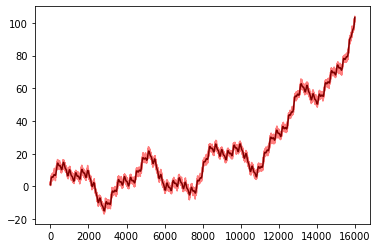

In [2]:
from synthgen import SyntheticDatasetGenerator
import matplotlib.pyplot as plt

stock_data = SyntheticDatasetGenerator(length=16000)
stock_data.add_sin_wave(amplitude=1, frequency=100)
stock_data.add_sin_wave(amplitude=2, frequency=50)
stock_data.add_sin_wave(amplitude=5, frequency=10)
stock_data.add_sin_wave(amplitude=10, frequency=4)
stock_data.add_exponential_growth(1.00029)
# stock_data_og.add_noise(mean=0, std=1)
og_signal = stock_data.data

stock_data.add_noise(mean=10, std=1)
y = stock_data.data

plt.plot(og_signal, color='black')
plt.plot(y, color='red', alpha=0.5)
# plt.plot(y)

In [3]:
from torch import optim
from torch import nn

def training(dominance_freq, seq_len, pred_len, epochs, og_signal=og_signal, y=y):
    # data
    num_samples = int(1e4)

    from models.FITS_padding import FITS
    from argparse import Namespace

    batch_size = 1

    args = Namespace(
        dominance_freq=dominance_freq,
        seq_len=seq_len,
        pred_len=pred_len,
        channels=1,
        individual=False,
        debug=True,
        num_hidden=64,
        num_layers=3,
        scalar=0.05,
    )

    model = FITS(args)

    model_optim = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    fits, train_loss = train(model, model_optim, criterion, args, batch_size, y, num_samples, epochs)
    
    return fits

In [4]:
def test(fits, train_ratio):
    num_samples = len(y)
    pred_len = fits.pred_len
    seq_len = fits.seq_len
    # train_ratio = 0.85

    from models.ARIMA import ARIMA
    from models.baseline import NaiveForecast
    from models.baseline import AverageForecast
    from parser import parser # type: ignore    

    # Prepare the data
    train_size = int(num_samples * train_ratio)
    train_data = y[:train_size]
    test_data = y[train_size:]

    # Initialize the baseline models and FITS
    args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
    naive = NaiveForecast(args_)
    arima = ARIMA(args_)
    average = AverageForecast(args_)

    # Train and test the baseline models
    start_idx = train_size - seq_len
    end_idx = train_size

    real_data = np.concatenate((train_data[start_idx:], test_data[:pred_len]), axis=0)

    og_signal_data = og_signal[:num_samples]
    og_signal_pred = og_signal_data[end_idx:end_idx+pred_len]

    def RMAE(output, target):
        return torch.sqrt(torch.mean(torch.abs(output - target)))

    criterion_mse = nn.MSELoss()
    criterion_rmae = RMAE

    # ARIMA
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = arima(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()

        output_arima = output[:, :pred_len, 0:]
        output_arima = output_arima.to(batch_y.device)
        loss_mse_arima = criterion_mse(output_arima, batch_y)
        loss_rmae_arima = criterion_rmae(output_arima, batch_y)

    # Naive Forecast
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = naive(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_naive = output[:, -pred_len:, :]
        loss_mse_naive = criterion_mse(output_naive, batch_y)
        loss_rmae_naive = criterion_rmae(output_naive, batch_y)

    # Average Forecast
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        
        output = average(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_average = output[:, -pred_len:, 0:]
        # output_average = output_average - 0.5 # for plotting purposes
        loss_mse_average = criterion_mse(output_average, batch_y)
        loss_rmae_average = criterion_rmae(output_average, batch_y)

    # FITS no arima
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = fits(batch_x)
        fits_output = output
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        batch_y = batch_y.to(output.device)
        output_fits = output[:, -pred_len:, 0:]
        loss_mse_fits_no_arima = criterion_mse(output_fits, batch_y)
        loss_rmae_fits_no_arima = criterion_rmae(output_fits, batch_y)

    # FITS + arima
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = fits(batch_x)
        fits_output = output
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        batch_y = batch_y.to(output.device)
        output_fits = output[:, -pred_len:, 0:] + output_arima - torch.mean(output[:, -pred_len:, 0:])
        loss_mse_fits = criterion_mse(output_fits, batch_y)
        loss_rmae_fits = criterion_rmae(output_fits, batch_y)


    og_signal_pred = torch.from_numpy(og_signal_pred).unsqueeze(0).unsqueeze(-1).float()
    og_signal_mse = criterion_mse(og_signal_pred, batch_y)
    og_signal_rmae = criterion_rmae(og_signal_pred, batch_y)
    
    baselines = [
        ("Original Signal", og_signal_data[start_idx:end_idx+pred_len], og_signal_mse, og_signal_rmae, "blue", "-"),
        ("ARIMA", output_arima, loss_mse_arima, loss_rmae_arima, "darkviolet", "-"),
        ("FITS + ARIMA", output_fits, loss_mse_fits, loss_rmae_fits, "magenta", "-"),
        ("FITS", fits_output, loss_mse_fits_no_arima, loss_rmae_fits_no_arima, "red", "-"),
        ("NF", output_naive, loss_mse_naive, loss_rmae_naive, "orange", "--"),
        ("Average", output_average, loss_mse_average, loss_rmae_average, "gray", "--"),
    ]

    test_output = [baselines, start_idx, end_idx, pred_len, real_data, fits, fits_output, og_signal_mse, loss_mse_arima, loss_mse_naive, loss_mse_average, loss_mse_fits, loss_mse_fits_no_arima]

    return test_output

In [5]:
def plots(test_output, ax, epochs):
    baselines, start_idx, end_idx, pred_len, real_data, fits, fits_output, og_signal_mse, loss_mse_arima, loss_mse_naive, loss_mse_average, loss_mse_fits, loss_mse_fits_no_arima = test_output
    print(pred_len)
    
    ax.plot(list(range(start_idx, start_idx + len(real_data))), real_data, label="Ground Truth", color="black")

    for name, output, mse, rmae, color, linestyle in baselines:
        mse_ = round(mse.item(), 4)
        mse_og = round(mse.item() - og_signal_mse.item(), 1)
        if name == "Original Signal":
            ax.plot(list(range(start_idx, end_idx + pred_len)), output, 
                    label=f"{name} [MSE: {mse_}]", linewidth=2.5, linestyle=linestyle, color=color)
        else:
            if name == "FITS":
                ax.plot(list(range(start_idx, end_idx + pred_len)), fits_output[0, :, 0], color=color)
                output = output[:, -pred_len:, 0:]
            ax.plot(list(range(end_idx, end_idx + pred_len)), output[0, :, 0], 
                    label=f"{name}* [MSE: {mse_} (-{mse_og})]" if mse == min(loss_mse_arima, loss_mse_naive, loss_mse_average, loss_mse_fits_no_arima) else f"{name} [MSE: {mse_} (-{mse_og})]", linestyle=linestyle, color=color)

    best = min(loss_mse_arima, loss_mse_naive, loss_mse_average, loss_mse_fits_no_arima)
    second_best_name = next(name for name, _, mse, _, _, _ in baselines if mse == best)
    improvement = best - loss_mse_fits

    ax.legend(loc="upper left")

    ax.axvline(x=end_idx, color="blue", linestyle="--", label="Forecast Start")

    ax.set_title(" ", fontsize=40)
    ax.text(0.5, 1.08, f"""FITS+ARIMA ({'+' if round(improvement.item(), 5) >= 0 else '-'}{abs(round(improvement.item(), 3))} {'better' if round(improvement.item(), 5) >= 0 else 'worse'} than {second_best_name}) vs. Baselines""", fontsize=14, ha='center', fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 1.03, f"""[seq_len={fits.seq_len}, pred_len={fits.pred_len}, dominance_freq={fits.cutoff_frequency}] epochs: {epochs}""", fontsize=12, ha='center', transform=ax.transAxes)

    ax.set_ylabel("Price (normalized)")
    ax.set_xlabel("Time")

epoch: 1000 loss: 1.08747560 val_loss: 1.0769052096
epoch: 1000 loss: 1.69955758 val_loss: 1.435530817192
epoch: 1000 loss: 5.41669801 val_loss: 4.012048323336
epoch: 1000 loss: 14.73295803 val_loss: 45.21830707720


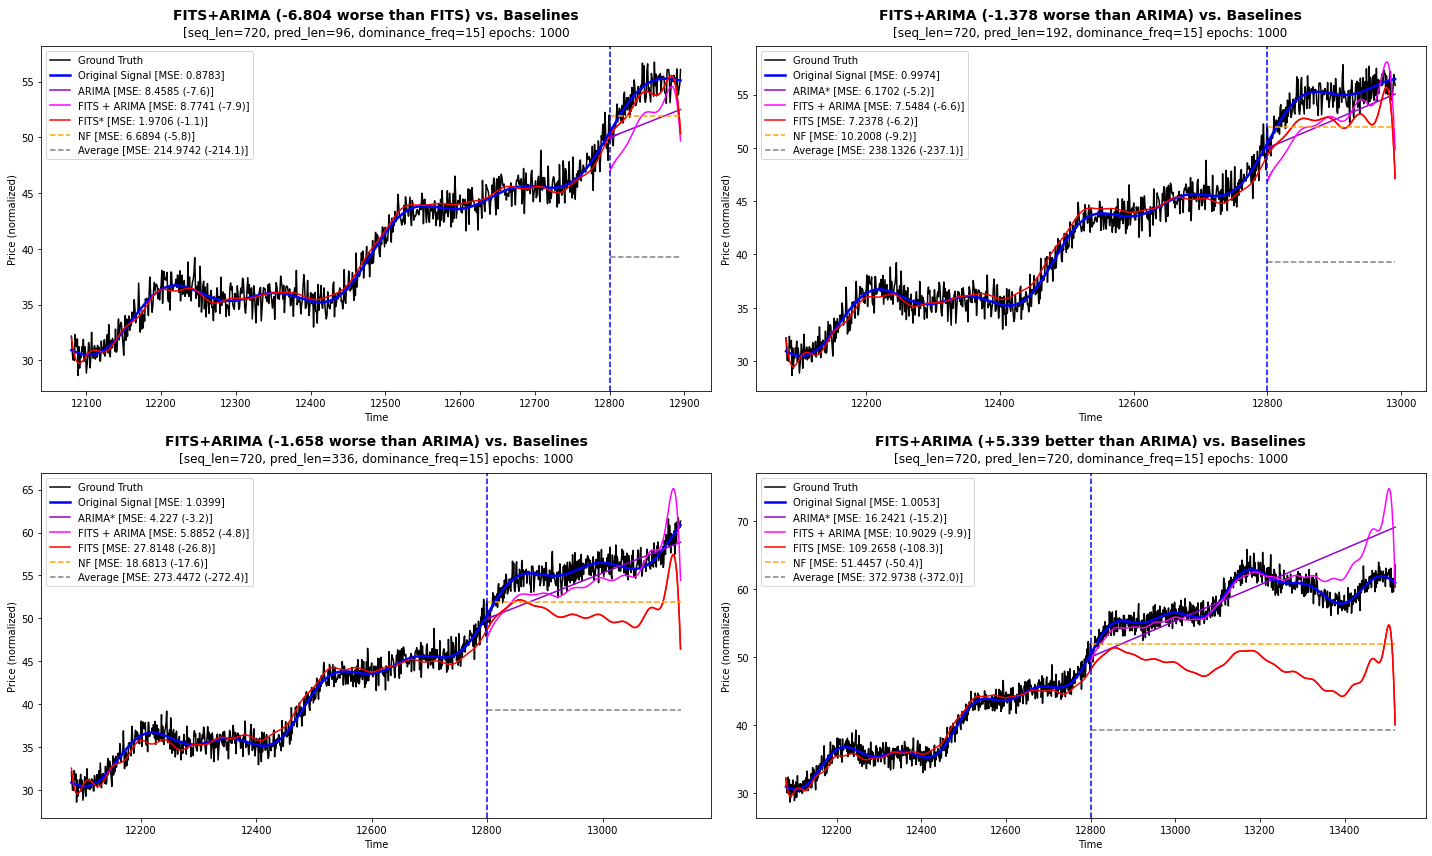

In [6]:
import matplotlib.pyplot as plt

pred_lens = [96, 192, 336, 720]
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
epochs = 1000
train_ratio = 0.8  # hacky way to see different batches

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    
    fits = training(dominance_freq=15, seq_len=720, pred_len=pred_len, epochs=epochs)  # comment these two out if you need to change plots 
    test_output = test(fits, train_ratio)                                              # without retraining the model
    plots(test_output, axs[row, col], epochs)

plt.tight_layout()
plt.show()

epoch: 1000 loss: 1.10254739 val_loss: 1.0612548496
epoch: 1000 loss: 1.68410439 val_loss: 2.399985603192
epoch: 1000 loss: 4.12745330 val_loss: 5.119461826336
epoch: 1000 loss: 28.00694058 val_loss: 22.49738636720


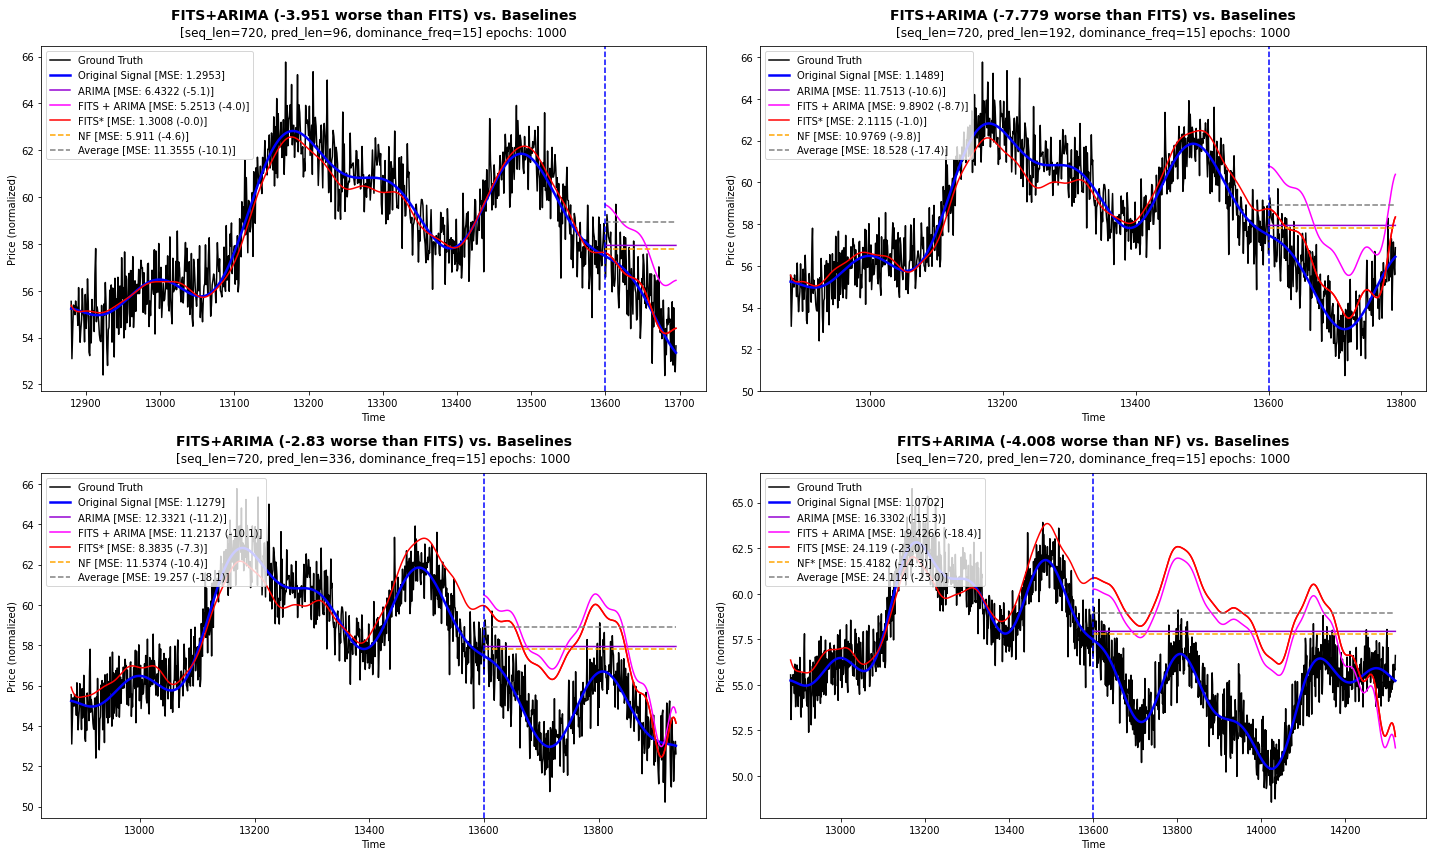

In [7]:
import matplotlib.pyplot as plt

pred_lens = [96, 192, 336, 720]
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
epochs = 1000
train_ratio = 0.85  # hacky way to see different batches

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    
    fits = training(dominance_freq=15, seq_len=720, pred_len=pred_len, epochs=epochs)  # comment these two out if you need to change plots 
    test_output = test(fits, train_ratio)                                              # without retraining the model
    plots(test_output, axs[row, col], epochs)

plt.tight_layout()
plt.show()

epoch: 1 loss: 16.93985895 val_loss: 17.36931047

epoch: 1000 loss: 1.14347343 val_loss: 1.0950337996
epoch: 1000 loss: 1.79078970 val_loss: 1.967668467192
epoch: 1000 loss: 4.43420175 val_loss: 3.736489639336
epoch: 1000 loss: 25.78213535 val_loss: 13.74512138720


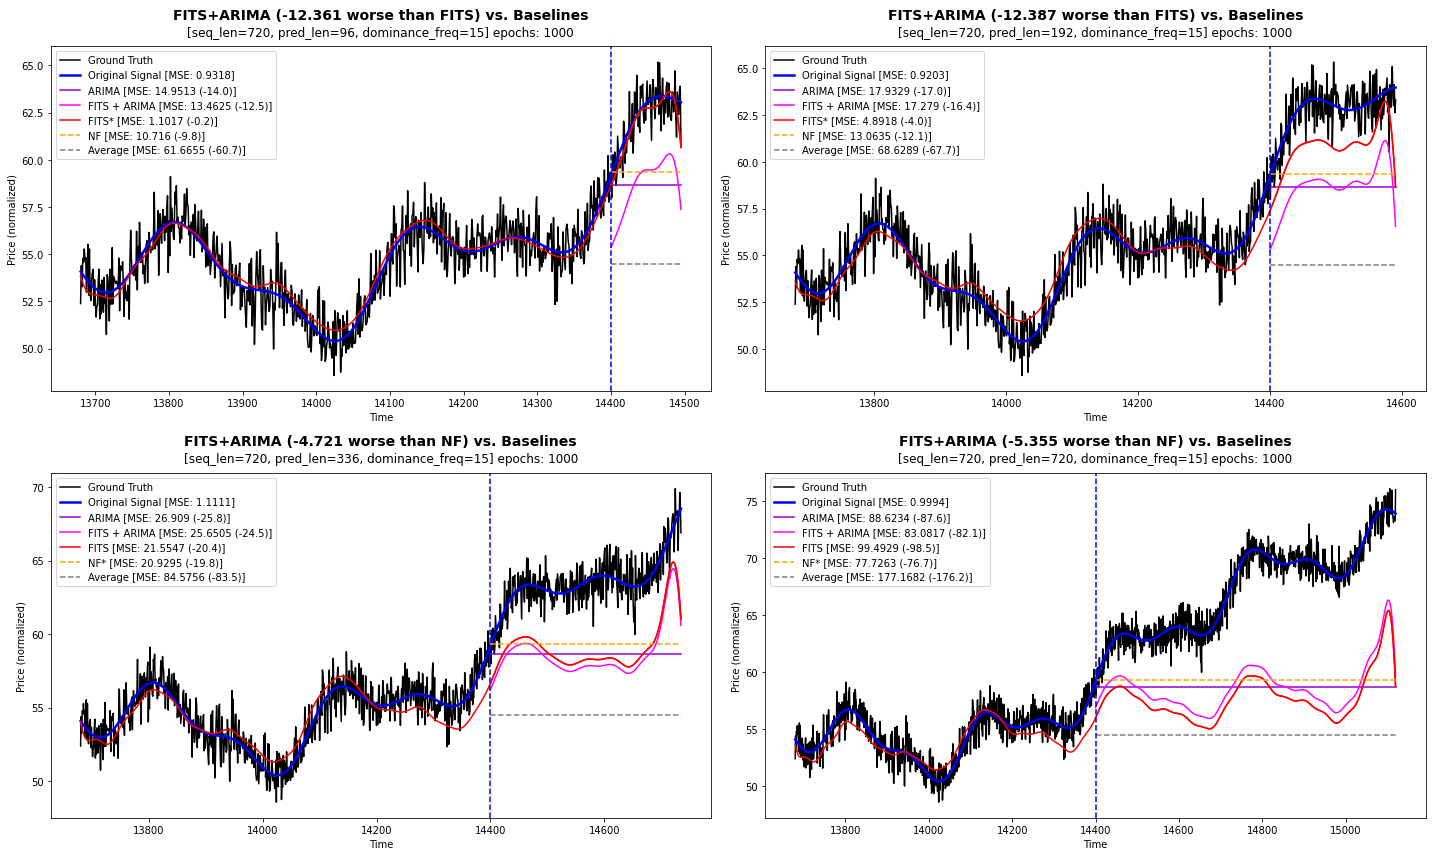

In [8]:
import matplotlib.pyplot as plt

pred_lens = [96, 192, 336, 720]
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
epochs = 1000
train_ratio = 0.9  # hacky way to see different batches

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    
    fits = training(dominance_freq=15, seq_len=720, pred_len=pred_len, epochs=epochs)  # comment these two out if you need to change plots 
    test_output = test(fits, train_ratio)                                              # without retraining the model
    plots(test_output, axs[row, col], epochs)

plt.tight_layout()
plt.show()